In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from chinese_calendar import is_workday, is_holiday
import chinese_calendar as calendar
import time, datetime
from numba import jit


In [3]:

text = pd.read_csv("PRSA_data.csv").convert_dtypes()


In [4]:
#preprocess:

#1.feature genertating
#
# text['time'] = text.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
# text = text.set_index('time')


#北风强度值
def transform_north(x):
    if(x.cbwd=='NE' or x.cbwd=='NW'):
        return x.Iws
    else: return 0

text['N_E'] = text.apply(lambda x: transform_north(x),axis=1 )


def transform_four_period(x):
    if(0<=x and x<=6): return 'night'
    elif(x<=12): return 'morning'
    elif(x<=18): return 'afternoon'
    else :return 'evening'
text['period'] = text.apply(lambda x: transform_four_period(x.hour),axis=1 )

#spring, summer, fall, winter

def transform_four_season(x):
    if(3<=x and x<=5): return 'spring'
    elif(x<=8): return 'summer'
    elif(x<=10): return 'fall'
    else :return 'winter'
text['season'] = text.apply(lambda x: transform_four_season(x.month),axis=1 )

#the week (weekdays, weekends, or holidays)
def transform_four_Week(year,month,day):
    now_date = datetime.date(year, month, day)
    on_holiday, holiday_name = calendar.get_holiday_detail(now_date)
    if(on_holiday): return 'weekends' if holiday_name is None else 'holiday'
    elif(is_workday(now_date)):return 'workday'
    else: return 'weekends'
text['Week'] = text.apply(lambda x: transform_four_Week(x.year,x.month,x.day),axis=1 )



def norm_to_float(c):
    element = text[c].unique()
    dictionary = dict(zip(element,range(0,len(element)))) #反转
    text[c] = text.apply(lambda x:dictionary[x[c]],axis=1)
    return dictionary
dict_period = norm_to_float('period')
dict_season = norm_to_float('season')
dict_Week = norm_to_float('Week')
# dict_PM2_5 = norm_to_float('pm2.5')





def transform_four_segment(x):
    if(8<=x and x<=9): return 'Morning_rush '
    elif(x<=17): return 'Work'
    elif(x<=19): return 'Evening_rush'
    else :return 'Home'
text['segment'] = text.apply(lambda x: transform_four_period(x.hour),axis=1 )
dict_Segment = norm_to_float('segment')


text['diff'] = text['DEWP']-text['N_E']

from sklearn.decomposition import PCA
pca  = PCA(n_components=1)
text['composition'] = pca.fit_transform(list(zip(text['DEWP'],-text['N_E'])))



text['cbwd'].unique()
text = text.join(pd.get_dummies(text['cbwd']).astype('float'))
del text['cbwd']

#2.processing the missing value
#from the segment3 ,this is the best choice :fill with mean
#We using the text to fillin to simplify ; The right way is to fill in with Train_set
text=text.fillna(int(text['pm2.5'].mean()))

In [5]:

#time period of the day (e.g, morning, afternoon, evening, night)
def generate_dataset(data):
    #先划分数据集
    Train_set=pd.DataFrame(columns=text.columns)
    Test_set=pd.DataFrame(columns=text.columns)
    text_data =data.groupby(['year','month','day'])
    for index,(name,data)  in enumerate(text_data):
        if((index+1)%7 ==0):
            Test_set =Test_set.append(data)
        else:
            Train_set = Train_set.append(data)

    return Train_set,Test_set
Train_set,Test_set = generate_dataset(text)



In [6]:
from xgboost import XGBClassifier,XGBRegressor
from sklearn.utils import shuffle

#shuffle True: 打乱顺序  select = "Regression" or other
def get_score(trainset,testset,select,shuffle=False):

    if(shuffle==True):
        trainset = shuffle(trainset)
        testset = shuffle(testset)
    x_train =trainset.astype("float")
    x_test =testset.astype("float")

    y_train =x_train.pop('pm2.5')
    y_test =x_test.pop('pm2.5')
    if(select=='Regression'):
        model = XGBRegressor()
    else:
        model = XGBClassifier()
    model.fit(x_train,y_train)
    predict = model.predict(x_test)
    score = model.score(x_test,y_test)
    return score,predict,y_test

In [7]:
scores,prediction,_ = get_score(Train_set,Test_set,'Regression')
scores

0.6851234386468754

In [8]:

from sklearn.utils import shuffle
Train_set = shuffle(Train_set)
Test_set = shuffle(Test_set)
X_train = Train_set.astype('float')
Y_train  = X_train.pop('pm2.5')
X_test =Test_set.astype('float')
Y_test =X_test.pop('pm2.5')

In [9]:
#Feature Selection:
#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
trees = RandomForestRegressor(n_estimators=150,random_state=0)
trees.fit(X_train,Y_train)
score = trees.score(X_test,Y_test)
print(score)
pd.DataFrame(
    {'feature': list(X_train.columns),'importance': trees.feature_importances_}).sort_values('importance', ascending = False)

0.6462167082047333


,feature,importance
16,diff,0.198812
0,No,0.182466
6,TEMP,0.105255
3,day,0.102244
2,month,0.089655
5,DEWP,0.079716
7,PRES,0.072655
17,composition,0.034462
4,hour,0.031143
8,Iws,0.025557


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

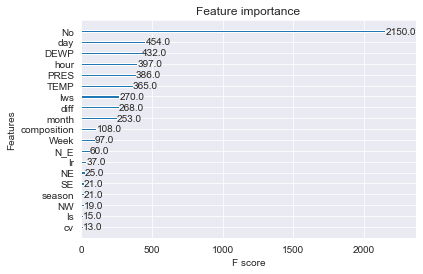

In [10]:
#XGBoosting
model = XGBRegressor()
model.fit(X_train,Y_train)
score = model.score(X_test,Y_test)
import xgboost as xgb
xgb.plot_importance(model)

In [11]:
## 皮尔逊相关系数
from scipy.stats import pearsonr
from sklearn.feature_selection import SelectKBest
# Y_predict=model.predict(X_test)
func_pearson = lambda X,y: list (np.array ([pearsonr (x,y) for x in X.T]).T)
X_filtered = SelectKBest(func_pearson, k = 5).fit_transform(X_train, Y_train)
skb=SelectKBest(func_pearson,k=8)
skb.fit(X_train,Y_train)
index =skb.get_support(indices=True)
index = pd.Series(index)
X_train.iloc[:,index]

,day,DEWP,Is,season,Week,diff,SE,cv
26624,14.0,-10.0,0.0,0.0,1.0,-10.00,0.0,1.0
38484,23.0,12.0,0.0,1.0,1.0,12.00,1.0,0.0
23107,20.0,20.0,0.0,0.0,1.0,16.87,0.0,0.0
26735,18.0,-11.0,0.0,0.0,1.0,-15.02,0.0,0.0
24091,30.0,6.0,0.0,2.0,0.0,6.00,1.0,0.0
...,...,...,...,...,...,...,...,...
5887,3.0,20.0,0.0,2.0,1.0,18.21,0.0,0.0
23762,17.0,12.0,0.0,2.0,1.0,9.32,0.0,0.0
1513,5.0,-10.0,0.0,1.0,1.0,-32.80,0.0,0.0
19724,1.0,-8.0,0.0,1.0,1.0,-8.00,1.0,0.0


In [12]:
from minepy import MINE
from sklearn.feature_selection import SelectKBest
#由于MINE的设计不是函数式的，定义mic方法将其为函数式的，返回一个二元组，二元组的第2项设置成固定的P值0.5
def mic(x, y):
    m = MINE()
    m.compute_score(x, y)
    return (m.mic(), 0.5)
# 选择K个最好的特征，返回特征选择后的数据
func_mic = lambda X,y: list(np.array([mic(x,y) for x in X.T]).T)
X_filtered_MIC = SelectKBest(func_mic,k = 8).fit(X_train.values,Y_train)
index =X_filtered_MIC.get_support(indices=True)
index = pd.Series(index)
X_train.iloc[:,index]

,No,DEWP,Iws,N_E,diff,composition,NW,SE
26624,26625.0,-10.0,1.78,0.00,-10.00,-15.595786,0.0,0.0
38484,38485.0,12.0,22.35,0.00,12.00,-18.008142,0.0,1.0
23107,23108.0,20.0,3.13,3.13,16.87,-15.774237,0.0,0.0
26735,26736.0,-11.0,4.02,4.02,-15.02,-11.490374,1.0,0.0
24091,24092.0,6.0,7.16,0.00,6.00,-17.350227,0.0,1.0
...,...,...,...,...,...,...,...,...
5887,5888.0,20.0,1.79,1.79,18.21,-17.106157,1.0,0.0
23762,23763.0,12.0,2.68,2.68,9.32,-15.344303,1.0,0.0
1513,1514.0,-10.0,22.80,22.80,-32.80,7.066730,1.0,0.0
19724,19725.0,-8.0,64.81,0.00,-8.00,-15.815091,0.0,1.0


In [13]:
#关于Lasso进行筛选
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
lasso_lars_aic = make_pipeline(
    StandardScaler(),LassoLarsIC(criterion='aic')
).fit(X_train,Y_train)
lasso_lars_aic[-1].criterion_

array([447121.40171972, 444841.17430507, 444575.19142183, 443544.92328496,
       442858.51264899, 439027.42981589, 438768.97410345, 437883.39271447,
       436115.45467365, 435812.32285005, 435719.7390968 , 435203.59594213,
       435093.06114816, 433483.77673423, 433358.19866919, 432882.95271071,
       432386.06076557, 432306.08895369, 432293.13069243, 432252.65405262,
       432241.71516072, 432184.82271161, 432184.78447236, 432182.98953445,
       432151.4636646 , 432151.42898969, 432102.13996889, 432091.23353152,
       432064.85490765, 432064.85490759])

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

#带L1惩罚项的逻辑回归作为基模型的特征选择
SelectFromModel(LogisticRegression(penalty="l2", C=0.1)).fit_transform(X_train,Y_train)

array([[26625.,  2013.,  1027.],
       [38485.,  2014.,  1010.],
       [23108.,  2012.,  1006.],
       ...,
       [ 1514.,  2010.,  1020.],
       [19725.,  2012.,  1016.],
       [26499.,  2013.,  1033.]])

In [15]:


from sklearn.decomposition import PCA
pca = PCA(n_components=7, whiten=True, random_state=0)
x = pca.fit_transform(Train_set) # arr.shape: sample_num * feature_num
print('各方向方差：', pca.explained_variance_)          # 上述协方差矩阵C的特征值（排序后的）
print('方差所占比例：', pca.explained_variance_ratio_)  # 上述协方差矩阵C的特征值在所有特征值加和中的占比
print("各方向的基：", pca.components_)                  # 新的坐标系的基
pca_p = pca.components_

各方向方差： [1.60224272e+08 1.16596027e+04 6.58307657e+03 5.08402907e+02
 1.52719467e+02 7.69572532e+01 5.55797065e+01]
方差所占比例： [9.99880790e-01 7.27618396e-05 4.10817396e-05 3.17269222e-06
 9.53047000e-07 4.80252326e-07 3.46845583e-07]
各方向的基： [[-9.99999873e-01 -1.09434306e-04 -5.51532856e-05 -1.16037625e-05
  -2.99027358e-07  1.66726953e-04 -5.54815608e-05 -7.48328067e-05
   2.03731775e-05  2.39601088e-04  1.67138541e-06  1.30232924e-06
   1.97125896e-04 -4.64132102e-08 -1.33824991e-05 -1.68590205e-06
  -4.64132102e-08 -2.52607456e-04  2.02020918e-04 -1.68767340e-07
   1.61288889e-06 -3.74087940e-08 -1.40671275e-06]
 [ 2.90652561e-04 -4.29602816e-05  6.38851173e-04 -4.06170770e-03
   2.29491394e-03 -5.37901028e-01 -5.43099163e-02 -2.02641650e-02
   2.42872016e-02  3.95957635e-01 -7.40971075e-05  1.84268554e-04
   4.08147496e-01  3.39871780e-04  1.39568853e-03 -1.72404853e-04
   3.39871780e-04 -4.62457412e-01  4.11641579e-01 -1.21448314e-04
   1.93824496e-03 -9.78397046e-04 -8.38399600e-04]
